In [12]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms.isomorphism import GraphMatcher
from itertools import combinations, chain
from mlxtend.frequent_patterns import apriori, association_rules

In [103]:
E1 = [("A", "B"), ("B", "C"), ("C", "A"), ("B", "D"), ("C", "D"), ("D", "E")]
E2 = [("A", "B"), ("B", "C"), ("C", "D"), ("D", "E")]
# E3 = [("A", "E"), ("A", "B"), ("A", "C"), ("A", "D")]

In [104]:
G1 = nx.from_edgelist(E1)
G2 = nx.from_edgelist(E2)
#G3 = nx.from_edgelist(E3)

In [105]:
GRAPH_DB = [G1, G2]

In [74]:

G3 = nx.from_edgelist(E1)


In [75]:
g = nx.from_edgelist([E1[0]])

In [76]:
tuple(g.nodes())

('A', 'B')

In [77]:
G3.number_of_nodes()

5

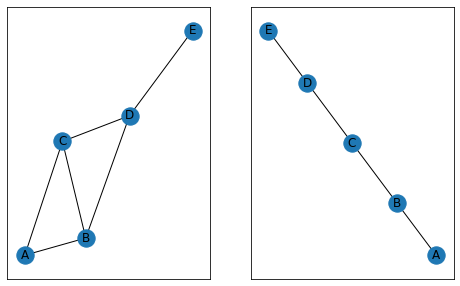

In [106]:
plt.figure(figsize=(8,5))
plt.figure(1)

plt.subplot(1,2,1)
nx.draw_networkx(G1)

plt.subplot(1,2,2)
nx.draw_networkx(G2)

plt.show()

In [125]:
from collections import defaultdict
# GRAPH_DB = [G1, G2]
# items_counted = dict()
# min_sup = 2
# edge_matrix = [E1, E2]
# frequent_total = list()

# G1 = nx.Graph()
# # G1 contains a subgraph between nodes 1-5 with 5 edges (this is the frequent pattern)
# G1.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (6, 1), (6, 2)])

# G2 = nx.Graph()
# # G2 contains the same subgraph between nodes 1-5, ensuring a frequent subgraph of size 5
# G2.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (6, 5), (6, 4)])

# # Edge lists to mimic the input structure in the example
# E1 = list(G1.edges())
# E2 = list(G2.edges())

GRAPH_DB = [G1, G2]  # List of graphs in the database
edge_matrix = [E1, E2]  # List of edge lists
min_sup = 2


def frequent_singletons(min_sup, edge_matrix):
    items_counted = {}
    for edge_list in edge_matrix:
        for edge in edge_list:
            items_counted[edge] = items_counted.get(edge, 0) + 1
    
    # Return frequent edges that meet the min_sup
    F = [key for key, value in items_counted.items() if value >= min_sup]
    
    # Convert frequent edges into individual graph objects
    F_graphs = [nx.Graph([edge]) for edge in F]  # Each edge is a graph now
    return F_graphs


def generate_candidates(F, k):
    # Generate combinations of subgraphs from frequent subgraphs of size (k-1)
    candidates = set()
    
    # Iterate over all pairs of frequent subgraphs (F)
    for g1, g2 in combinations(F, 2):
        # Combine the two subgraphs if they share a common (k-1)-sized subgraph
        union_graph = nx.compose(g1, g2)
        
        if nx.is_connected(union_graph):
        # Ensure the new graph has exactly k edges
            if union_graph.number_of_edges() == k:
                candidates.add(union_graph)
    
    return candidates


def count_support(C, graph_db):
    F_count = {}
    for graph in graph_db:
        for candidate in C:
            GM = GraphMatcher(graph, candidate)
            if GM.subgraph_is_isomorphic():  # Check for subgraph isomorphism
                F_count[candidate] = F_count.get(candidate, 0) + 1
    return F_count


def filter_frequent(F_count, min_sup):
    return [key for key, value in F_count.items() if value >= min_sup]


# Main function to run the frequent subgraph mining algorithm
def apriori_graph_mining(min_sup, edge_matrix, graph_db, max_k):
    frequent_total = []
    
    # Step 1: Find frequent singletons (edges)
    F = frequent_singletons(min_sup, edge_matrix)
    
    # Add initial frequent items to the total list
    frequent_total.extend(F)
    
    k = 2  # Start with size-2 subgraphs
    while k <= max_k:
        print(f"\nIteration {k}:")
        
        # Step 2: Generate candidate subgraphs of size k
        C = generate_candidates(F, k)
        
        # Step 3: Count support for each candidate in the graph database
        F_count = count_support(C, graph_db)
        
        # Step 4: Filter out frequent candidates that meet the minimum support
        F = filter_frequent(F_count, min_sup)
        
        if not F:  # If no frequent candidates are found, stop the algorithm
            print(f"No frequent subgraphs found for size {k}. Terminating.")
            break
        
        # Add frequent items to the total list
        frequent_total.extend(F)
        
        print(f"Frequent subgraphs of size {k}: {F}")
        
        k += 1  # Move to the next size of subgraphs

    return frequent_total


In [122]:
new_new_C = generate_candidates(new_C, 5)

for i in new_new_C:
    print(i.edges())

[('A', 'B'), ('B', 'C'), ('C', 'D')]
[('C', 'D'), ('C', 'B'), ('D', 'E')]
[('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E')]


In [126]:
frequents = apriori_graph_mining(2, edge_matrix, GRAPH_DB, 5)
for pattern in frequents:
    print(pattern.edges())


Iteration 2:
Frequent subgraphs of size 2: [<networkx.classes.graph.Graph object at 0x0000029D638EFC10>, <networkx.classes.graph.Graph object at 0x0000029D638EF040>, <networkx.classes.graph.Graph object at 0x0000029D638EFF70>]

Iteration 3:
Frequent subgraphs of size 3: [<networkx.classes.graph.Graph object at 0x0000029D638EFB80>, <networkx.classes.graph.Graph object at 0x0000029D638EDC60>]

Iteration 4:
No frequent subgraphs found for size 4. Terminating.
[('A', 'B')]
[('B', 'C')]
[('C', 'D')]
[('D', 'E')]
[('C', 'D'), ('D', 'E')]
[('B', 'C'), ('C', 'D')]
[('A', 'B'), ('B', 'C')]
[('B', 'C'), ('B', 'A'), ('C', 'D')]
[('C', 'D'), ('C', 'B'), ('D', 'E')]


In [27]:
for i in frequents:
    print(i.nodes())

[1, 2]
[1, 5]
[2, 3]
[3, 4]
[4, 5]
[2, 3, 4]
[1, 2, 3, 4]
[1, 2, 4, 5]
[1, 2, 5]
[1, 5, 2, 3]
[1, 2, 3]
[1, 5, 4]
[2, 3, 4, 5]
[1, 5, 3, 4]
[3, 4, 5]
[2, 3, 4, 1]
[2, 3, 4, 5]
[2, 3, 4, 1]
[1, 5, 4, 3]
[1, 2, 5, 3]
[1, 2, 4, 5]
[1, 2, 5, 4]
[1, 5, 3, 4]
[1, 5, 4, 3]
[1, 2, 5, 3]
[1, 2, 4, 5]
[1, 5, 2, 3]
[2, 3, 4, 5]
[1, 2, 3, 4]
[2, 3, 4, 5]
[1, 5, 4, 3, 2]
[2, 3, 4, 1, 5]
[1, 2, 4, 5, 3]
[2, 3, 4, 5, 1]
[1, 2, 5, 4, 3]
[1, 5, 4, 3, 2]
[1, 2, 5, 4, 3]
[1, 2, 5, 3, 4]
[1, 2, 4, 5, 3]
[2, 3, 4, 5, 1]
[1, 2, 4, 5, 3]
[1, 2, 4, 5, 3]
[2, 3, 4, 5, 1]
[1, 5, 3, 4, 2]
[2, 3, 4, 1, 5]
[1, 5, 4, 3, 2]
[1, 5, 3, 4, 2]
[1, 2, 3, 4, 5]
[1, 5, 4, 3, 2]
[2, 3, 4, 1, 5]
[2, 3, 4, 1, 5]
[1, 2, 5, 3, 4]
[1, 2, 5, 4, 3]
[1, 5, 3, 4, 2]
[2, 3, 4, 1, 5]
[1, 5, 4, 3, 2]
[2, 3, 4, 5, 1]
[2, 3, 4, 1, 5]
[1, 2, 5, 3, 4]
[2, 3, 4, 1, 5]
[1, 5, 4, 3, 2]
[1, 2, 5, 4, 3]
[2, 3, 4, 1, 5]
[1, 2, 5, 3, 4]
[1, 2, 4, 5, 3]
[2, 3, 4, 1, 5]
[1, 5, 2, 3, 4]
[2, 3, 4, 5, 1]
[1, 2, 5, 3, 4]
[1, 2, 5, 3, 4]
[1, 5, 4, 3, 2]


Iteration 2:
Frequent subgraphs of size 2: [<networkx.classes.graph.Graph object at 0x000001CCB4321360>]

Iteration 3:
No frequent subgraphs found for size 3. Terminating.

Final frequent subgraphs:
[(4, 5)]
[(5, 6)]
[(4, 5), (5, 6)]


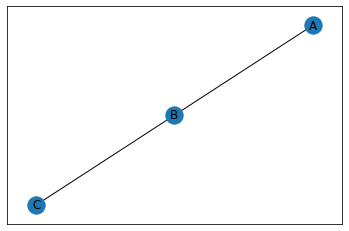

In [14]:
nx.draw_networkx(frequents[-1])

In [78]:
frequent_total["F2"][0].edges()

EdgeView([('A', 'B'), ('B', 'C')])

In [96]:
nx.weisfeiler_lehman_graph_hash(G1) == nx.weisfeiler_lehman_graph_hash(G3)

True

In [85]:
h = [('A', 'B'), ('B', 'C')]
l = [('A', 'B'), ('B', 'C')]
h == l

True

In [12]:
frequent_total

{'F1': [('A', 'B'), ('B', 'C'), ('D', 'E')],
 'F2': [<networkx.classes.graph.Graph at 0x14fd8f13640>]}

In [121]:
print(F1)

[('A', 'B'), ('B', 'C'), ('D', 'E')]


In [35]:
pos = (C.subgraph(c).copy() for c in nx.connected_components(C))

subgraphs_splitted = (C(c).copy() for c in nx.connected_components(C))

print(pos)

<generator object <genexpr> at 0x0000021EFFEDD230>


In [36]:
candidate_subgraphs = dict()
for i, sg in enumerate(pos):
    name = "G" + str(i)
    candidate_subgraphs[name] = sg

print(candidate_subgraphs)

{'G0': <networkx.classes.graph.Graph object at 0x0000021E853EDAE0>, 'G1': <networkx.classes.graph.Graph object at 0x0000021E853EFFD0>}


In [37]:
for key, value in candidate_subgraphs.items():
    print(value)

Graph with 3 nodes and 2 edges
Graph with 2 nodes and 1 edges


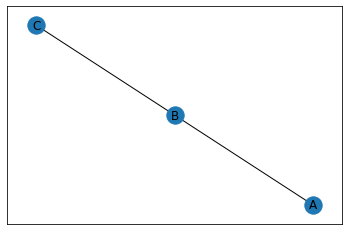

In [38]:
nx.draw_networkx(candidate_subgraphs["G0"])

In [39]:
frequent_items2 = dict()
for graph in GRAPH_DB:
    for key, subgraph in candidate_subgraphs.items():

        GM = GraphMatcher(graph, subgraph)
        is_isomorphic = GM.subgraph_is_monomorphic()

        if is_isomorphic:
            edges = tuple(subgraph.edges())
            frequent_items2[edges] = frequent_items2.get(edges, 0) + 1
            


In [40]:
frequent_items2

{}

In [41]:
frequent_items

[('A', 'B'), ('B', 'C'), ('D', 'E')]

In [17]:
test = [("A", "B")]
G3 = nx.from_edgelist(test)

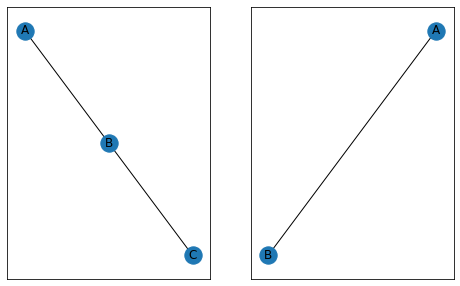

In [46]:
plt.figure(figsize=(8,5))
plt.figure(1)

plt.subplot(1,2,1)
nx.draw_networkx(C)

plt.subplot(1,2,2)
nx.draw_networkx(G3)

plt.show()

In [202]:
GM = GraphMatcher(G1, G2)

In [203]:
GM.subgraph_is_monomorphic()

True

In [204]:
GM.subgraph_is_isomorphic()

False

In [131]:
sub = G1.subgraph(["A", "B", "C"])

In [135]:
path = nx.path_graph(["A", "B", "C"])

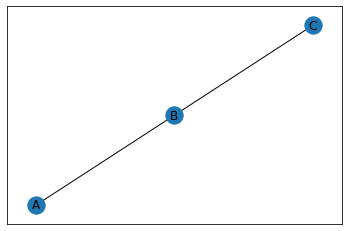

In [136]:
nx.draw_networkx(path)

In [79]:
for edge in frequent_items:
    print(G1.has_edge(*edge))

True
True
False


In [83]:
def accepts(g, path):
    return all([(path[i],path[i+1]) in g.edges() for i in range(len(path)-1)])

In [98]:
accepts(G2, new_path2)

False

In [7]:
counts = dict()
items = ['apple', 'red', 'apple', 'red', 'red', 'pear']
for item in items:
    counts[item] = counts.get(item, 0) + 1

In [8]:
counts

{'apple': 2, 'red': 3, 'pear': 1}

In [166]:
for nodes in combinations(G1.nodes, G2.number_of_nodes()):
    subgraph = nx.subgraph(nodes)
    print(subgraph.edges)
    
    GM = GraphMatcher(subgraph, G2)

    iso = GM.is_isomorphic()
    
    if iso:
        print("Yes")
    else:
        print("No")


[('A', 'B'), ('B', 'C'), ('C', 'D')]
No
[('A', 'B'), ('B', 'C'), ('C', 'E')]
No
[('A', 'B'), ('B', 'D'), ('D', 'E')]
No
[('A', 'C'), ('C', 'D'), ('D', 'E')]
No
[('B', 'C'), ('C', 'D'), ('D', 'E')]
No


In [145]:
E3 = [('B', 'C'), ('C', 'D')]
E4 = [('A', 'B'), ('B', 'C')]
G3 = nx.from_edgelist(E3)
G4 = nx.from_edgelist(E4)

GM = GraphMatcher(G3, G4)
GM.is_isomorphic()

True

In [142]:
subgraph.nodes

NodeView(('B', 'C', 'D'))

In [143]:
subgraph.edges

EdgeView([('B', 'C'), ('C', 'D')])

In [13]:
edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('B', 'D'),
    ('C', 'D'),
]

from collections import defaultdict

# Create a dictionary to hold the neighbors of each node
node_neighbors = defaultdict(set)

# Populate the dictionary with edges
for edge in edges:
    node_neighbors[edge[0]].add(edge[1])
    node_neighbors[edge[1]].add(edge[0])

# Convert the dictionary to a list of transactions (neighborhoods)
transactions = [list(neighbors) for neighbors in node_neighbors.values()]
print(transactions)

[['B', 'C'], ['D', 'A', 'C'], ['B', 'D', 'A'], ['B', 'C']]


In [14]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

# Initialize the transaction encoder
te = TransactionEncoder()

# Fit and transform the transactions into a one-hot encoded array
te_ary = te.fit(transactions).transform(transactions)

# Convert the array to a pandas DataFrame
df = pd.DataFrame(te_ary, columns=te.columns_)
print(df)


       A      B      C      D
0  False   True   True  False
1   True  False   True   True
2   True   True  False   True
3  False   True   True  False


In [15]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply the Apriori algorithm with a minimum support threshold
frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)

# Generate association rules with a minimum confidence threshold
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Print the resulting rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


  antecedents consequents  support  confidence  lift
0         (D)         (A)      0.5         1.0   2.0
1         (A)         (D)      0.5         1.0   2.0


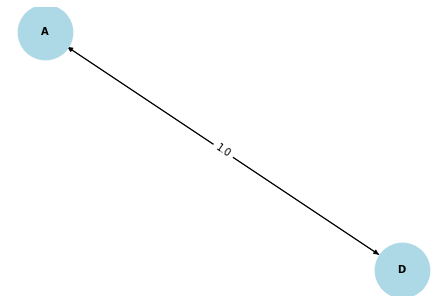

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph for the association rules
G = nx.DiGraph()

# Add edges for each association rule
for index, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['confidence'])

# Plot the network graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")

# Draw edge labels for confidence values
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: round(v, 2) for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


In [18]:
import networkx as nx
from itertools import combinations

# Helper function to count the support of a subgraph in the graph database
def count_support(subgraph, graph_db):
    support_count = 0
    for graph in graph_db:
        if nx.isomorphism.GraphMatcher(graph, subgraph).subgraph_is_isomorphic():
            support_count += 1
    return support_count

# Function to generate candidate subgraphs
def generate_candidates(frequent_subgraphs, k):
    candidates = []
    for g1, g2 in combinations(frequent_subgraphs, 2):
        if len(set(g1.nodes).intersection(g2.nodes)) == (k - 1):  # Join on common (k-1) nodes
            union_graph = nx.compose(g1, g2)
            candidates.append(union_graph)
    return candidates



In [51]:
from itertools import chain
l1 = [1,2]
l2 = [2,3]

set(chain(l1, l2))

{1, 2, 3}